In [1]:
import os
import pickle
from PIL import Image
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.links.caffe import CaffeFunction

from matplotlib import pylab as plt

# モデルの読み込み

In [2]:
%%time
MODEL = 'model/bvlc_googlenet.caffemodel'
PICKLE = 'model/ggnet.pkl'
if os.path.exists(PICKLE):
    print("Load pickle")
    with open(PICKLE, 'rb') as pkl:
        model = pickle.load(pkl)
else:
    print("Load caffemodel and make pickle")
    if os.path.exists(MODEL):
        model = CaffeFunction(MODEL)
        with open(PICKLE, 'wb') as pkl:
            pickle.dump(model, pkl)
    print(MODEL + " not found.")

Load pickle
CPU times: user 60.4 ms, sys: 64 ms, total: 124 ms
Wall time: 125 ms


# GoogLeNetのモデル

In [43]:
class GoogLeNet(Chain):
    insize = 224
    
    def __init__(self):
        super(GoogLeNet, self).__init__()
        with self.init_scope():
            self.conv1 =  L.Convolution2D(3, 64, 7, stride=2, pad=3)
            self.conv2_reduce = L.Convolution2D(64, 64, 1)
            self.conv2 = L.Convolution2D(64, 192, 3, stride=1, pad=1)
            self.inception_3a = L.Inception(192, 64, 96, 128, 16, 32, 32)
            self.inception_3b = L.Inception(256, 128, 128, 192, 32, 96, 64)
            self.inception_4a = L.Inception(480, 192, 96, 208, 16, 48, 64)
            self.inception_4b = L.Inception(512, 160, 112, 224, 24, 64, 64)
            self.inception_4c = L.Inception(512, 128, 128, 256, 24, 64, 64)
            self.inception_4d = L.Inception(512, 112, 144, 288, 32, 64, 64)
            self.inception_4e = L.Inception(528, 256, 160, 320, 32, 128, 128)
            self.inception_5a = L.Inception(832, 256, 160, 320, 32, 128, 128)
            self.inception_5b = L.Inception(832, 384, 192, 384, 48, 128, 128)
            loss3_fc = L.Linear(1024, 1000)
            
            loss1_conv = L.Convolution2D(512, 128, 1)
            loss1_fc1 = L.Linear(2048, 1024)
            loss1_fc2 = L.Linear(1024, 1000)
            
            loss2_conv = L.Convolution2D(528, 128, 1)
            loss2_fc1 = L.Linear(2048, 1024)
            loss2_fc2 = L.Linear(1024, 1000)
        
    def __call__(self, x, train=True):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 3, stride=2)
        h = F.local_response_normalization(h, n=5, k=1, alpha=2e-05)
        h = F.relu(self.conv2_reduce(h))
        h = F.relu(self.conv2(h))
        h = F.local_response_normalization(h, n=5, k=1, alpha=2e-05)
        h = F.max_pooling_2d(h, 3, stride=2)
        
        h = self.inception_3a(h)
        h = self.inception_3b(h)
        h = F.max_pooling_2d(h, 3, stride=2)
        h = self.inception_4a(h)
        
        b = F.average_pooling_2d(h, 5, stride=3)
        b = F.relu(self.loss1_conv(b))
        b = F.relu(self.loss1_fc1(b))
        b = self.loss1_fc2(b)
        
        h = self.inception_4b(h)
        h = self.inception_4c(h)
        h = self.inception_4d(h)
        
        b = F.average_pooling_2d(h, 5, stride=3)
        b = F.relu(self.loss2_conv(b))
        b = F.relu(self.loss2_fc1(b))
        b = self.loss2_fc2(b)
        
        h = self.inception_4e(h)
        h = F.max_pooling_2d(h, 3, stride=2)
        h = self.inception_5a(h)
        h = self.inception_5b(h)
        
        h = F.average_pooling_2d(h, 7, stride=1)
        y = self.loss3_fc(F.dropout(h, 0.4, train=train))
        return y

In [44]:
ggn = GoogLeNet()

# モデルの係数をコピーする

In [5]:
# Wとbにはそれぞれこんなのが入っている
ggn.conv1.W

variable W([[[[ -3.27311247e-03,   1.29488721e-01,  -7.51904771e-02, ...,
                 2.32334323e-02,   5.11870943e-02,   3.35645825e-02],
              [ -2.03503054e-02,   2.44707763e-02,   1.06302321e-01, ...,
                -3.07226870e-02,   2.23207977e-02,   1.60575157e-03],
              [  3.00176460e-02,   3.64298932e-02,   7.88858859e-04, ...,
                -1.43969923e-01,   4.92123328e-02,   1.27435863e-01],
              ..., 
              [  4.32179607e-02,   3.04637421e-02,  -5.50107025e-02, ...,
                -5.91920726e-02,   1.06675111e-01,   2.67140754e-02],
              [  4.16177101e-02,   7.44467741e-03,  -6.55962080e-02, ...,
                -9.24054906e-02,   6.97643459e-02,   2.00017586e-01],
              [  1.06574707e-01,  -8.02749675e-03,   3.20614614e-02, ...,
                -1.32742827e-03,  -1.79951265e-01,   6.96668699e-02]],

             [[ -5.84505349e-02,  -3.28947790e-02,  -1.00884456e-02, ...,
                -5.91286942e-02,  -2.481

In [6]:
ggn.conv1.b

variable b([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
             0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
             0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
             0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
             0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
             0.,  0.,  0.,  0.])

## gnn に 読み込んだmodelを確認コピーする

In [7]:
# コピー先
ggn.conv1.W.shape

(64, 3, 7, 7)

In [8]:
# コピー元
model['conv1/7x7_s2'].W.shape

(64, 3, 7, 7)

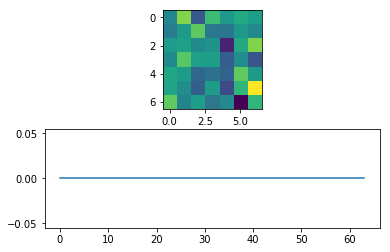

In [9]:
# 初期化しかされていない畳み込みフィルタの一つ
plt.subplot(211)
plt.imshow(ggn.conv1.W[0,0].data)

plt.subplot(212)
plt.plot(ggn.conv1.b.data)
plt.show()

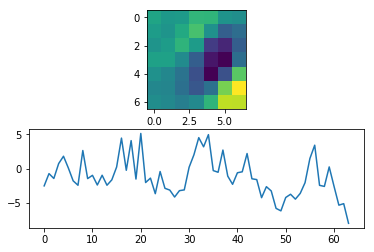

In [10]:
# 学習済の畳み込みフィルタの一つ

plt.subplot(211)
plt.imshow(model['conv1/7x7_s2'].W[0,0].data)

plt.subplot(212)
plt.plot(model['conv1/7x7_s2'].b.data)
plt.show()

In [11]:
# コピーする
ggn.conv1.W = model['conv1/7x7_s2'].W
ggn.conv1.b = model['conv1/7x7_s2'].b

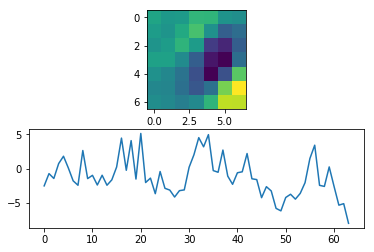

In [12]:
# [再実行]初期化しかされていない畳み込みフィルタの一つ
plt.subplot(211)
plt.imshow(ggn.conv1.W[0,0].data)

plt.subplot(212)
plt.plot(ggn.conv1.b.data)
plt.show()

# 更新を許容するか決める

In [41]:
ggn.enable_update()

In [42]:
ggn.update_enabled

False